### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_curve, roc_auc_score, RocCurveDisplay


### Load Dataset

In [2]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Combine features and target
df = pd.concat(
    [breast_cancer_wisconsin_diagnostic.data.features,
     breast_cancer_wisconsin_diagnostic.data.targets],
    axis=1
)

target_col = df.columns[-1]
print("The Target Column is:", target_col)

X = df.drop(columns=target_col)
y = df[target_col]

print("\nData shape:", X.shape)
print("Target distribution:\n", y.value_counts())

The Target Column is: Diagnosis

Data shape: (569, 30)
Target distribution:
 Diagnosis
B    357
M    212
Name: count, dtype: int64


### Train-Test Split

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)
# Now train=70%, val=10%, test=20%
print("\nTrain size:", X_train.shape, "Val size:", X_val.shape, "Test size:", X_test.shape)


Train size: (398, 30) Val size: (57, 30) Test size: (114, 30)


### Preprocessing

In [4]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns  

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


### Pipeline

In [5]:
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(class_weight="balanced"))
])

### Hyperparameter Tuning with GridSearchCV

In [6]:
param_grid = {
    "clf__max_depth": [3, 5, 10, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"]
}

kf = KFold(n_splits=5, shuffle=True)

grid = GridSearchCV(
    pipe, param_grid, cv=kf,
    scoring={"accuracy": "accuracy", "f1_weighted": "f1_weighted"},
    refit="accuracy", n_jobs=-1, verbose=1
)

grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

param_dist = {
    "clf__max_depth": [3, 5, 10, None],
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 10),
    "clf__criterion": ["gini", "entropy"]
}

random_search = RandomizedSearchCV(
    pipe, param_distributions=param_dist,
    n_iter=20, cv=kf, scoring={"accuracy": "accuracy", "f1_weighted": "f1_weighted"},
    refit="accuracy",
    n_jobs=-1, verbose=1, random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)
if(grid.best_score_>random_search.best_score_):
    best_param = grid.best_params_
    best_model = grid.best_estimator_  
else:
    best_param=random_search.best_params_
    best_model = random_search.best_estimator_  

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}
Best CV Score: 0.9347468354430379
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 13}
Best CV Score: 0.9547784810126583


In [7]:
grid_results = pd.DataFrame(grid.cv_results_)
grid_results = grid_results[[
    "mean_test_accuracy", "mean_test_f1_weighted", "params"
]]
grid_results["source"] = "GridSearch"

# Extract results from RandomizedSearch
random_results = pd.DataFrame(random_search.cv_results_)
random_results = random_results[[
    "mean_test_accuracy", "mean_test_f1_weighted", "params"
]]
random_results["source"] = "RandomizedSearch"

# Combine
all_results = pd.concat([grid_results, random_results], ignore_index=True)

# Sort by accuracy (or f1 if you prefer)
top_models = all_results.sort_values(
    by="mean_test_accuracy", ascending=False
).head(5)

print("\nTop 5 Models across GridSearch & RandomizedSearch:")
print(top_models.to_string(index=False))


Top 5 Models across GridSearch & RandomizedSearch:
 mean_test_accuracy  mean_test_f1_weighted                                                                                                          params           source
           0.954778               0.954664    {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 13} RandomizedSearch
           0.952247               0.952122    {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 11} RandomizedSearch
           0.947278               0.947318  {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 3} RandomizedSearch
           0.947152               0.947368 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 13} RandomizedSearch
           0.944652               0.944752   {'clf__criterion': 'entropy', 'clf__max_dep

### Cross Validation

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    best_model, X_train, y_train,
    cv=cv,
    scoring=["accuracy", "f1_weighted"],
    n_jobs=-1,
    return_train_score=False
)

print("\n--- 5-Fold Cross Validation on Best Model ---")
for i, (acc, f1) in enumerate(zip(cv_results["test_accuracy"], cv_results["test_f1_weighted"]), 1):
    print(f"Fold {i}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

print("\nMean Accuracy:", cv_results["test_accuracy"].mean())
print("Mean F1:", cv_results["test_f1_weighted"].mean())


--- 5-Fold Cross Validation on Best Model ---
Fold 1: Accuracy = 0.9375, F1 = 0.9381
Fold 2: Accuracy = 0.9375, F1 = 0.9380
Fold 3: Accuracy = 0.9625, F1 = 0.9626
Fold 4: Accuracy = 0.8987, F1 = 0.8992
Fold 5: Accuracy = 0.8987, F1 = 0.8987

Mean Accuracy: 0.926993670886076
Mean F1: 0.9273235611267591


### Model Results

In [9]:
model = best_model
preds = model.predict(X_val)
print(f"\n--- Validation Results ---")
print("Accuracy:", accuracy_score(y_val, preds))
print("Precision:", precision_score(y_val, preds, average="weighted"))
print("Recall:", recall_score(y_val, preds, average="weighted"))
print("F1:", f1_score(y_val, preds, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_val, preds))


--- Validation Results ---
Accuracy: 0.9473684210526315
Precision: 0.9484620642515378
Recall: 0.9473684210526315
F1: 0.9476097712345061
Confusion Matrix:
 [[34  2]
 [ 1 20]]


### Test Evaluation

In [10]:
final_model =  best_model
test_preds = final_model.predict(X_test)

print("\n===== Final Test Results =====")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds, average="weighted"))
print("Recall:", recall_score(y_test, test_preds, average="weighted"))
print("F1:", f1_score(y_test, test_preds, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
print("\nClassification Report:\n", classification_report(y_test, test_preds))


===== Final Test Results =====
Accuracy: 0.9385964912280702
Precision: 0.9384352963933389
Recall: 0.9385964912280702
F1: 0.9384383268099622
Confusion Matrix:
 [[69  3]
 [ 4 38]]

Classification Report:
               precision    recall  f1-score   support

           B       0.95      0.96      0.95        72
           M       0.93      0.90      0.92        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



### Visualization

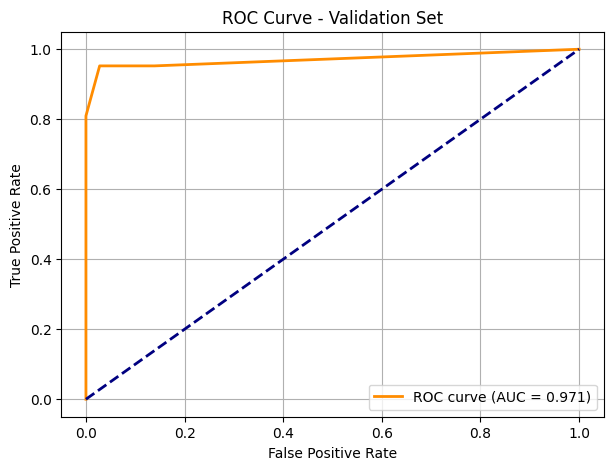

In [11]:
y_val_proba = model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label="M")
roc_auc = roc_auc_score(y_val, y_val_proba)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

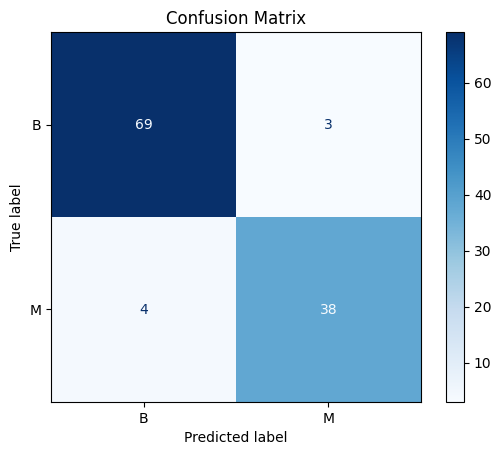

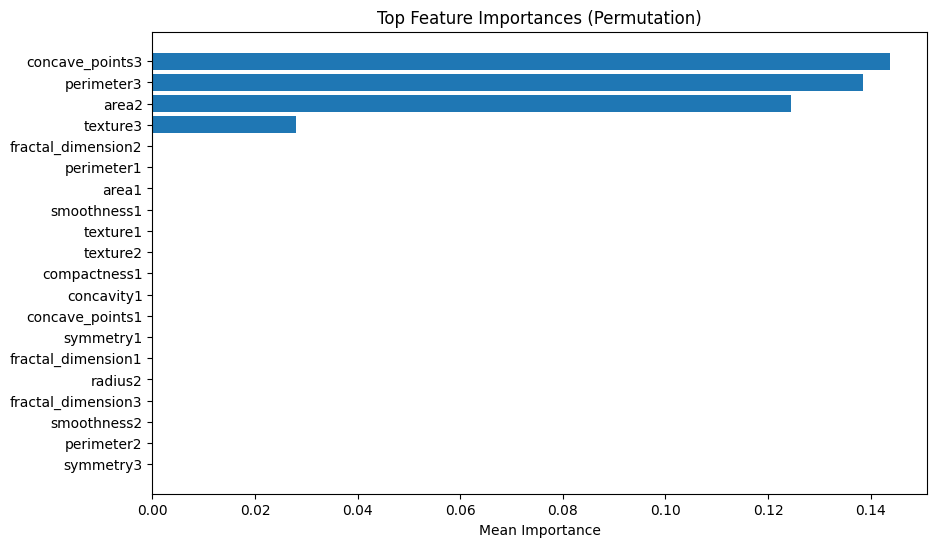

In [12]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

best_model.fit(X_train, y_train)

# 🔹 Access the fitted ColumnTransformer (inside pipeline after fit)
preprocessor_fitted = None
for step_name, step in best_model.named_steps.items():
    if isinstance(step, ColumnTransformer):
        preprocessor_fitted = step
        break

if preprocessor_fitted is None:
    raise ValueError("No ColumnTransformer found inside best_model pipeline!")

# 🔹 Now get feature names safely
num_feature_names = list(num_features)
cat_encoder = preprocessor_fitted.named_transformers_["cat"]

# ✅ Make sure encoder is fitted by transforming once
cat_encoder.fit(X[cat_features])

cat_feature_names = list(cat_encoder.get_feature_names_out(cat_features))
feature_names = num_feature_names + list(cat_feature_names)

# 🔹 Permutation importance
r = permutation_importance(best_model, X_val, y_val,
                           n_repeats=10, random_state=42, n_jobs=-1)

# 🔹 Plot top features
sorted_idx = r.importances_mean.argsort()[::-1][:20]
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx], r.importances_mean[sorted_idx])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Permutation)")
plt.xlabel("Mean Importance")
plt.show()